Environment, state-space, action-space and rewards modeling

In [ ]:
import gym
from gym import spaces
import numpy as np
import matplotlib.pyplot as plt

class ThermalEnvironment(gym.Env):
    metadata = {'render.modes': ['human']}
    GLIDE_LOSS_PER_CELL = 15 # Altitude loss per cell moved, based on the glide ratio

    def __init__(self, grid_size=(10, 10), max_altitude=2000, initial_altitude=1000, min_altitude=500, max_thermals=30, max_steps=100):
        super(ThermalEnvironment, self).__init__()

        self.grid_size = grid_size
        self.max_altitude = max_altitude
        self.min_altitude = min_altitude
        self.initial_altitude = initial_altitude
        self.max_thermals = max_thermals
        self.thermal_grid = np.zeros(self.grid_size)  # Thermal map of the environment
        self.known_thermals = np.zeros(self.grid_size)  # Shared known thermals
        self.max_steps=max_steps

        # Agent specific
        self.num_agents = 2
        self.agent_positions = [np.array([0, 0]), np.array([grid_size[0]-1, grid_size[1]-1])]  # Example initial positions
        self.agent_altitudes = np.array([initial_altitude for _ in range(self.num_agents)])

        self.current_hour = 9  # Example start time, could be sunrise or any start of simulation time
        self.cumulative_flight_time = 0  # Track the total flight time in hours
        self.num_altitude_levels = max_altitude - min_altitude
        self.num_hours = 12

        # Define the action and observation spaces
        # Gliding actions ==> 0: up, 1: down, 2: left, 3: right
        # Cruising actions ==> 4: up, 5: down, 6: left, 7: right
        # 8: emergency climb
        self.action_space = spaces.Discrete(9)
        self.observation_space = spaces.Dict({
            'position': spaces.MultiDiscrete([grid_size[0], grid_size[1]] * self.num_agents),
            'altitude': spaces.Box(low=min_altitude, high=max_altitude, shape=(self.num_agents,), dtype=np.float32),
            'thermal_detected': spaces.MultiBinary(self.num_agents)
        })

        self.first_reset = False

    def reset(self, full_reset=False):

        if full_reset :  # 6 hours threshold
            # Reset everything to initial conditions
            self.agent_positions = [np.array([0, 0]), np.array([self.grid_size[0]-1, self.grid_size[1]-1])]
            self.agent_altitudes = np.array([self.initial_altitude for _ in range(self.num_agents)])
            self.known_thermals = np.zeros(self.grid_size)
            self.thermal_grid = np.zeros(self.grid_size)
            self.current_hour = 9
            self.cumulative_flight_time = 0  # Reset cumulative time

        # Generate the initial thermals
        self.update_environment(self.current_hour)

        return self._get_obs()

    def update_environment(self, hour):
        """
        Update the thermal environment based on the hour of the day.
        """
        self.clear_thermals()  # Clear previous thermals
        # Thermal generation logic
        self.generate_thermals_with_poisson(hour)

    def _apply_action(self, agent_index, action):
        # Movement actions
        if action < 4:  # Gliding
            delta = [(0, -1), (0, 1), (-1, 0), (1, 0)][action]  # up, down, left, right
        else:  # Cruising (4-7)
            delta = [(0, -1), (0, 1), (-1, 0), (1, 0)][action - 4]  # Adjust delta for cruising actions

        new_position = self.agent_positions[agent_index] + np.array(delta)

        # Check bounds and adjust new_position if it's outside the grid
        new_position[0] = np.clip(new_position[0], 0, self.grid_size[0] - 1)
        new_position[1] = np.clip(new_position[1], 0, self.grid_size[1] - 1)

        # Update agent's position
        self.agent_positions[agent_index] = new_position

    def step(self, actions):
        rewards = np.zeros(self.num_agents)
        dones = np.array([False] * self.num_agents)
        emergency_climb_time_cost = 0 # Initialize time costs for this step
        action_time_cost = 0
        time_cost = 0
        thermaling_time_cost = 0

        buffer = 100  # Define a buffer below max_altitude
        penalty_for_min_altitude = 200
        penalty_for_max_altitude = 50  # Define a penalty for reaching max altitude
        emergency_descent_time_cost = 2 / 3600  # Assuming 2 seconds for the descent, converted to hours

        for i in range(self.num_agents):
            action = actions[i]
            energy_expenditure = 0
            altitude_change = 0  # To track altitude gained or lost

            if action == 8:  # Emergency climb
                # Assuming emergency climb takes 40 seconds
                emergency_climb_time_cost = 40/3600  # Use the emergency climb time cost in this step
                time_cost += emergency_climb_time_cost
                if self.agent_altitudes[i] <= self.min_altitude:
                    altitude_gain = self._emergency_climb()
                    self.agent_altitudes[i] = min(self.max_altitude, self.agent_altitudes[i] + altitude_gain)
                    energy_expenditure = 200  # Assuming a fixed energy cost for emergency climb
                    altitude_change += altitude_gain  # Count altitude gain from emergency climbing
                    rewards[i] -= penalty_for_min_altitude
            else:
                # Assuming all other actions take 2 seconds
                action_time_cost = 2/3600  # Use the action time cost in this step
                time_cost += action_time_cost
                prev_altitude = self.agent_altitudes[i]  # Store previous altitude for calculating change
                self._apply_action(i, action)

                if action < 4:  # Gliding actions (0-3) incur altitude loss
                    self.agent_altitudes[i] = max(self.min_altitude, self.agent_altitudes[i] - self.GLIDE_LOSS_PER_CELL)
                else:  # Cruising actions (4-7) maintain altitude but incur energy cost
                    energy_expenditure = 50  # Example energy cost for cruising

                altitude_change = self.agent_altitudes[i] - prev_altitude  # Calculate net altitude change

            # Check and handle thermal lift after moving
            thermal_present = self._check_thermal_presence(i)
            if thermal_present:
                altitude_gain = self._thermal_lift_gain(i)
                projected_altitude = self.agent_altitudes[i] + altitude_gain

                if self.agent_altitudes[i] < self.max_altitude - buffer:
                    # Gain altitude from the thermal if below the buffer zone
                    new_altitude = min(self.max_altitude, projected_altitude)
                    altitude_change = new_altitude - self.agent_altitudes[i]
                    self.agent_altitudes[i] = new_altitude  # Update the agent's altitude
                    # Adjust time cost based on thermal intensity
                    thermal_intensity = self.thermal_grid[self.agent_positions[i][0], self.agent_positions[i][1]]
                    thermaling_time_cost = (10 / thermal_intensity) / 60
                    time_cost += thermaling_time_cost
                elif self.agent_altitudes[i] >= self.max_altitude:
                    # Apply a penalty if at max altitude, initiate an emergency descent
                    rewards[i] -= penalty_for_max_altitude
                    self.agent_altitudes[i] = max(self.min_altitude, self.agent_altitudes[i] - self._emergency_descent())
                    time_cost += emergency_descent_time_cost
                    continue
                else:
                    # Close to max altitude, so avoid gaining more altitude from the thermal
                    continue

            # Update rewards based on altitude change and energy expenditure
            rewards[i] += altitude_change - energy_expenditure  # Soft reward: Altitude change minus energy expenditure

            # Update known_thermals and check episode completion
            if thermal_present:
                pos = self.agent_positions[i]
                self.known_thermals[pos[0], pos[1]] = 1

            dones[i] = self.agent_altitudes[i] < self.min_altitude
            if dones[i]:
                rewards[i] -= 100  # Additional penalty for going below minimum altitude

        # Update time and environment AFTER processing all actions and before returning the observation
        self.time_cost = time_cost
        self.current_hour += time_cost
        if self.current_hour >= 24:
            self.current_hour = 0  # Reset to 0 after reaching midnight
        # Update the environment based on the new hour
        self.update_environment(self.current_hour)

        return self._get_obs(), rewards, dones, {}



    def _get_obs(self):
        # Construct the observation for each agent including immediate surrounding thermal information
        obs = []
        for i in range(self.num_agents):
            agent_pos = self.agent_positions[i]
            # Get thermal information for adjacent grids
            adjacent_thermal_info = self._get_adjacent_thermal_info(agent_pos)
            obs_dict = {
                'position': agent_pos,
                'altitude': self.agent_altitudes[i],
                'thermal_detected': self._check_thermal_presence(i),
                'adjacent_thermals': adjacent_thermal_info,  # New information about adjacent grids
            }
            obs.append(obs_dict)
        return obs

    def _get_adjacent_thermal_info(self, agent_pos):
        # Extract information about known thermals in adjacent grids
        thermal_info = np.zeros((3, 3))  # Represents the surrounding grids including the current position
        for dx in range(-1, 2):
            for dy in range(-1, 2):
                nx, ny = agent_pos[0] + dx, agent_pos[1] + dy
                # Check bounds
                if 0 <= nx < self.grid_size[0] and 0 <= ny < self.grid_size[1]:
                    thermal_info[dx+1, dy+1] = self.known_thermals[nx, ny]
        return thermal_info.flatten()  # Flatten to a 1D array for simplicity

    def _check_thermal_presence(self, agent_index):
        # Check if there's a thermal at the current position of the agent
        pos = self.agent_positions[agent_index]
        if self.thermal_grid[pos[0], pos[1]] > 0:
            # If a thermal is detected, update the known thermals map
            self.known_thermals[pos[0], pos[1]] = 1
            return 1
        return 0

    def _thermal_lift_gain(self, agent_index):
        pos = self.agent_positions[agent_index]  # Retrieve the agent's current position
        thermal_intensity = self.thermal_grid[pos[0], pos[1]]  # The thermal intensity at the agent's position, directly from the thermal grid
        altitude_gain_proportional_factor = 100 # Assuming altitude gain is directly proportional to the thermal intensity. Change as needed
        altitude_gain = thermal_intensity * altitude_gain_proportional_factor # Calculate altitude gain as directly proportional to thermal intensity
        return altitude_gain

    def _emergency_climb(self):
        # Returns the altitude gain from performing an emergency climb
        # Adjust the value as needed to simulate the engine-powered climb
        return 200  # Example altitude gain for emergency climb

    def _emergency_descent(self):
        """
        Calculate the altitude loss during an emergency descent.
        This function simulates the rapid descent a glider would make to avoid dangerous situations or to decrease altitude quickly.
        """
        # Define a fixed altitude loss for emergency descent, could be based on the glider's capabilities and safety protocols
        altitude_loss = 100  # Example altitude loss in meters
        return altitude_loss

    def update_environment(self, hour):
        """Update the thermal environment based on the hour of the day."""
        self.clear_thermals()  # Clear previous thermals
        self.generate_thermals_with_poisson(hour)

    def generate_thermals_with_poisson(self, hour):
        """Generate thermals using a Poisson point process, with activity peaking at noon."""
        λ = self._calculate_lambda(hour)  # Rate parameter for Poisson process
        num_thermals = np.random.poisson(λ)
        for _ in range(min(num_thermals, self.max_thermals)):
            x, y = np.random.randint(0, self.grid_size[0]), np.random.randint(0, self.grid_size[1])
            strength = np.random.uniform(0.5, 2.0) * (1 - np.abs(hour - 12) / 12)  # Stronger thermals around noon
            self.thermal_grid[x, y] = strength

    def _calculate_lambda(self, hour):
        """Calculate the rate parameter λ for the Poisson distribution, peaking at noon."""
        return 8 * (1 - np.abs(hour - 12) / 12)  # Example: λ peaks at 15 at noon

    def clear_thermals(self):
        """Reset the thermal grid for a new update."""
        self.thermal_grid = np.zeros(self.grid_size)

    def plot_thermal_grid(self, hour):
        """Plot the thermal grid as a heatmap."""
        plt.imshow(self.thermal_grid, cmap='hot', interpolation='nearest')
        plt.colorbar(label='Thermal Strength')
        plt.title(f'Thermal Grid at Hour {hour}')
        plt.xlabel('X Coordinate')
        plt.ylabel('Y Coordinate')
        plt.show()



Initializing the environment

Initial State: [{'position': array([0, 0]), 'altitude': 100, 'thermal_detected': 0, 'adjacent_thermals': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'position': array([9, 9]), 'altitude': 100, 'thermal_detected': 0, 'adjacent_thermals': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}]
Next State: [{'position': array([0, 0]), 'altitude': 85, 'thermal_detected': 0, 'adjacent_thermals': array([0., 0., 0., 0., 0., 0., 0., 0., 0.])}, {'position': array([9, 8]), 'altitude': 209, 'thermal_detected': 0, 'adjacent_thermals': array([0., 0., 0., 0., 1., 0., 0., 0., 0.])}] Reward: [-15.         124.05941436] Done: [False False]


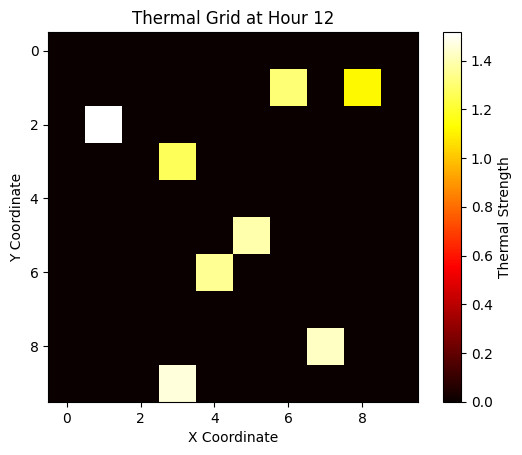

In [ ]:
# Assuming ThermalEnvironment is defined as shown in your provided snippets
env = ThermalEnvironment(grid_size=(10, 10), max_altitude=1000, initial_altitude=100, min_altitude=50, max_thermals=30, max_steps=10)

initial_state = env.reset()
print("Initial State:", initial_state)

# Assuming the action space is as defined, try taking a sample action
sample_actions = [0, 0]
next_state, reward, done, info = env.step(sample_actions)
print("Next State:", next_state, "Reward:", reward, "Done:", done)

env.plot_thermal_grid(12)

Q-learning

In [ ]:
# Discretization parameters
num_altitude_levels = 1500
num_hours = 12
epsilon_start = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
epsilon = epsilon_start  # Exploration rate
total_episodes = 5000  # Total number of episodes to train
max_steps = 100  # Max steps per episode to prevent infinitely long episodes
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor

def discretize_state(agent_state, env):
    """
    Converts an agent's state into discrete indices for the Q-table.

    Args:
    - agent_state: The state dictionary for a single agent.
    - env: The environment instance, to access its parameters.

    Returns:
    - A tuple of discretized state indices (x, y, altitude_level, hour_index).
    """
    x, y = agent_state['position']
    altitude = agent_state['altitude']

    # Discretize position based on grid size
    x_index = np.clip(x, 0, env.grid_size[0] - 1)
    y_index = np.clip(y, 0, env.grid_size[1] - 1)

    # Discretize altitude into levels
    altitude_level = int((altitude / env.max_altitude) * (env.num_altitude_levels - 1))
    altitude_level = np.clip(altitude_level, 0, env.num_altitude_levels - 1)

    # Discretize the hour (assuming current_hour is maintained correctly in the environment)
    hour_index = int((env.current_hour / env.num_hours) * env.num_hours)
    hour_index = np.clip(hour_index, 0, env.num_hours - 1)

    return (x_index, y_index, altitude_level, hour_index)

def calculate_energy_expenditure(action):
    """
    Calculate the energy expenditure based on the action taken.

    Args:
    - action: The action taken by the agent.
    - info: Additional information from the environment (unused in this case).

    Returns:
    - The energy expenditure of the action.
    """
    # Define energy costs for different actions. Adjust values as needed.
    energy_costs = {
        0: 0,  # Gliding up
        1: 0,  # Gliding down
        2: 0,  # Gliding left
        3: 0,  # Gliding right
        4: 10,  # Cruising up
        5: 10,  # Cruising down
        6: 10,  # Cruising left
        7: 10,  # Cruising right
        8: 100  # Emergency climb
    }

    # Return the energy cost associated with the action
    return energy_costs.get(action, 0)

# Initialize the Q-table
# Assuming action_space = 9, grid_size = (10, 10)
q_table = np.zeros((10, 10, num_altitude_levels, num_hours, 9))

# Logging
episode_rewards = []
epsilon_values = []

env.cumulative_flight_time = 0  # Initialize cumulative flight time

def select_action(q_table, discretized_state, epsilon):
    # Explore or exploit
    if np.random.rand() < epsilon:
        return np.random.randint(9)  # Assuming 9 possible actions
    else:
        # Exploit based on Q-table; adjust indexing based on discretized state format
        return np.argmax(q_table[discretized_state])

def update_q_table(q_table, discretized_state, action, reward, discretized_next_state, alpha, gamma):
    # Update rule for Q-learning; adjust indexing for discretized states
    q_predict = q_table[discretized_state + (action,)]
    q_target = reward + gamma * np.max(q_table[discretized_next_state])
    q_table[discretized_state + (action,)] += alpha * (q_target - q_predict)


# Example initialization of environment parameters for discretization
env.num_altitude_levels = 10  # Adding this as an example
env.num_hours = 12  # Adding this to maintain consistency

for episode in range(total_episodes):

    if env.cumulative_flight_time >= 6:
        raw_state = env.reset(full_reset=True)  # Full reset after 6 hours
    else:
        raw_state = env.reset(full_reset=False)

    state = [discretize_state(agent_state, env) for agent_state in raw_state]  # Discretize state for each agent

    done = [False] * env.num_agents
    episode_time = 0  # Track time spent in this episode
    total_rewards = 0

    for step in range(max_steps):
        actions = []
        for i, agent_state in enumerate(state):
            action = select_action(q_table, agent_state, epsilon)
            actions.append(action)

        raw_next_state, rewards, done, _ = env.step(actions)
        next_state = [discretize_state(agent_state, env) for agent_state in raw_next_state]  # Discretize next state for each agent
        episode_time += env.time_cost

        for i in range(env.num_agents):
            update_q_table(q_table, state[i], actions[i], rewards[i], next_state[i], alpha, gamma)

        state = next_state
        total_rewards += sum(rewards)

        if all(done):
            break

    # Epsilon decay and logging
    env.cumulative_flight_time += episode_time
    epsilon = max(epsilon_min, epsilon * epsilon_decay)
    episode_rewards.append(total_rewards)
    epsilon_values.append(epsilon)

    if episode % 100 == 0:
        average_reward = np.mean(episode_rewards[-100:])
        print(f"Episode {episode}: Average Reward: {average_reward}, Epsilon: {epsilon}")

Episode 0: Average Reward: -5036.862714579913, Epsilon: 0.995
Episode 100: Average Reward: -3800.2425167293495, Epsilon: 0.6027415843082742
Episode 200: Average Reward: -2259.218786441513, Epsilon: 0.36512303261753626
Episode 300: Average Reward: -963.0694887472441, Epsilon: 0.2211807388415433
Episode 400: Average Reward: -261.94664723031633, Epsilon: 0.13398475271138335
Episode 500: Average Reward: 203.3916434382274, Epsilon: 0.0811640021330769
Episode 600: Average Reward: 375.5110634761709, Epsilon: 0.04916675299948831
Episode 700: Average Reward: 594.3179753255732, Epsilon: 0.029783765425331846
Episode 800: Average Reward: 679.0623599220692, Epsilon: 0.018042124582040707
Episode 900: Average Reward: 751.3540858048519, Epsilon: 0.010929385683282892
Episode 1000: Average Reward: 777.265811358818, Epsilon: 0.01
Episode 1100: Average Reward: 712.8246935024596, Epsilon: 0.01
Episode 1200: Average Reward: 733.7062922249736, Epsilon: 0.01
Episode 1300: Average Reward: 754.2953503382315, Ep

SARSA

In [ ]:
# Discretization and learning parameters are the same as for Q-learning
num_altitude_levels = 1500
num_hours = 12
epsilon_start = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
epsilon = epsilon_start  # Exploration rate
total_episodes = 5000  # Total number of episodes to train
max_steps = 100  # Max steps per episode to prevent infinitely long episodes
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor

# The discretize_state and calculate_energy_expenditure functions remain the same

# Initialize the Q-table for SARSA
q_table_sarsa = np.zeros((10, 10, num_altitude_levels, num_hours, 9))

# Logging for SARSA
episode_rewards_sarsa = []
epsilon_values_sarsa = []

env.cumulative_flight_time = 0  # Initialize cumulative flight time

def select_action_sarsa(q_table, discretized_state, epsilon):
    # Explore or exploit for SARSA
    if np.random.rand() < epsilon:
        return np.random.randint(9)  # Assuming 9 possible actions
    else:
        return np.argmax(q_table[discretized_state])

def update_q_table_sarsa(q_table, state, action, reward, next_state, next_action, alpha, gamma):
    # SARSA update rule
    q_predict = q_table[state + (action,)]
    q_target = reward + gamma * q_table[next_state + (next_action,)]  # Use Q-value of the next action
    q_table[state + (action,)] += alpha * (q_target - q_predict)

for episode in range(total_episodes):
    if env.cumulative_flight_time >= 6:
          raw_state = env.reset(full_reset=True)  # Full reset after 6 hours
    else:
          raw_state = env.reset(full_reset=False)
    states = [discretize_state(agent_state, env) for agent_state in raw_state]  # Discretize initial states for each agent
    actions = [select_action_sarsa(q_table_sarsa, state, epsilon) for state in states]  # Select initial actions for each agent

    total_rewards = 0
    episode_time = 0  # Track time spent in this episode
    for step in range(max_steps):
        raw_next_states, rewards, dones, _ = env.step(actions)  # Execute actions for all agents
        episode_time += env.time_cost
        next_states = [discretize_state(agent_state, env) for agent_state in raw_next_states]  # Discretize next states for each agent
        next_actions = [select_action_sarsa(q_table_sarsa, next_state, epsilon) for next_state in next_states]  # Select next actions for each agent

        # Update Q-table using SARSA rule for each agent
        for i in range(env.num_agents):
            state, action, reward, next_state, next_action = states[i], actions[i], rewards[i], next_states[i], next_actions[i]
            update_q_table_sarsa(q_table_sarsa, state, action, reward, next_state, next_action, alpha, gamma)

        states, actions = next_states, next_actions  # Update states and actions for the next step
        total_rewards += np.sum(rewards)

        if all(dones):
            break

    # Epsilon decay and logging
    env.cumulative_flight_time += episode_time
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    episode_rewards_sarsa.append(total_rewards)
    epsilon_values_sarsa.append(epsilon)

    if episode % 100 == 0:
        avg_reward = np.mean(episode_rewards_sarsa[-100:])
        print(f"SARSA - Episode {episode}: Average Reward: {avg_reward}, Epsilon: {epsilon}")


SARSA - Episode 0: Average Reward: -4747.298443964408, Epsilon: 0.995
SARSA - Episode 100: Average Reward: -4000.3568783228784, Epsilon: 0.6027415843082742
SARSA - Episode 200: Average Reward: -2380.945162324612, Epsilon: 0.36512303261753626
SARSA - Episode 300: Average Reward: -1113.3742424640136, Epsilon: 0.2211807388415433
SARSA - Episode 400: Average Reward: -314.6125743061386, Epsilon: 0.13398475271138335
SARSA - Episode 500: Average Reward: 186.7249913533968, Epsilon: 0.0811640021330769
SARSA - Episode 600: Average Reward: 452.73297898183074, Epsilon: 0.04916675299948831
SARSA - Episode 700: Average Reward: 597.112311979549, Epsilon: 0.029783765425331846
SARSA - Episode 800: Average Reward: 692.1453153081613, Epsilon: 0.018042124582040707
SARSA - Episode 900: Average Reward: 723.4496222715228, Epsilon: 0.010929385683282892
SARSA - Episode 1000: Average Reward: 785.7380577004823, Epsilon: 0.01
SARSA - Episode 1100: Average Reward: 760.0935030223045, Epsilon: 0.01
SARSA - Episode 1

Expected SARSA



In [ ]:
# Discretization and learning parameters are the same as for Q-learning and SARSA
num_altitude_levels = 1500
num_hours = 12
epsilon_start = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
epsilon = epsilon_start  # Exploration rate
total_episodes = 5000  # Total number of episodes to train
max_steps = 100  # Max steps per episode
alpha = 0.1  # Learning rate
gamma = 0.99  # Discount factor

# Initialize the Q-table for Expected SARSA
q_table_expected_sarsa = np.zeros((10, 10, num_altitude_levels, num_hours, 9))

# Logging for Expected SARSA
episode_rewards_expected_sarsa = []
epsilon_values_expected_sarsa = []

env.cumulative_flight_time = 0  # Initialize cumulative flight time

def expected_sarsa_update(q_table, state, action, reward, next_state, epsilon, alpha, gamma):
    """
    Perform Expected SARSA Q-value update.
    """
    all_actions = range(9)  # Assuming 9 actions
    policy_prob = np.ones(len(all_actions)) * epsilon / len(all_actions)
    policy_prob[np.argmax(q_table[next_state])] += (1.0 - epsilon)

    expected_q = np.dot(q_table[next_state], policy_prob)
    q_predict = q_table[state + (action,)]
    q_target = reward + gamma * expected_q
    q_table[state + (action,)] += alpha * (q_target - q_predict)

for episode in range(total_episodes):

    if env.cumulative_flight_time >= 6:
        raw_state = env.reset(full_reset=True)  # Full reset after 6 hours
    else:
        raw_state = env.reset(full_reset=False)

    states = [discretize_state(agent_state, env) for agent_state in raw_state]  # Discretize initial states for each agent
    actions = [select_action_sarsa(q_table_expected_sarsa, state, epsilon) for state in states]  # Select initial actions for each agent

    total_rewards = 0
    episode_time = 0  # Track time spent in this episode

    for step in range(max_steps):
        raw_next_states, rewards, dones, _ = env.step(actions)  # Execute actions for all agents
        episode_time += env.time_cost  # Update episode time using the time_cost from the environment
        next_states = [discretize_state(agent_state, env) for agent_state in raw_next_states]  # Discretize next states for each agent
        next_actions = [select_action_sarsa(q_table_expected_sarsa, next_state, epsilon) for next_state in next_states]  # Select next actions for each agent

        # Update Q-table using Expected SARSA rule for each agent
        for i in range(env.num_agents):
            state, action, reward, next_state, next_action = states[i], actions[i], rewards[i], next_states[i], next_actions[i]
            expected_sarsa_update(q_table_expected_sarsa, state, action, reward, next_state, next_action, alpha, gamma)

        states, actions = next_states, next_actions  # Update states and actions for the next step
        total_rewards += np.sum(rewards)

        if all(dones):
            break

    # Epsilon decay and logging
    env.cumulative_flight_time += episode_time
    epsilon = max(epsilon_min, epsilon_decay * epsilon)
    episode_rewards_expected_sarsa.append(total_rewards)
    epsilon_values_expected_sarsa.append(epsilon)

    if episode % 100 == 0:
        avg_reward = np.mean(episode_rewards_expected_sarsa[-100:])
        print(f"Expected SARSA - Episode {episode}: Average Reward: {avg_reward}, Epsilon: {epsilon}")


Expected SARSA - Episode 0: Average Reward: -4031.1547961461556, Epsilon: 0.995
Expected SARSA - Episode 100: Average Reward: -4077.2820096773394, Epsilon: 0.6027415843082742
Expected SARSA - Episode 200: Average Reward: -3267.3956854460585, Epsilon: 0.36512303261753626
Expected SARSA - Episode 300: Average Reward: -2756.4042882501726, Epsilon: 0.2211807388415433
Expected SARSA - Episode 400: Average Reward: -2190.377051604389, Epsilon: 0.13398475271138335
Expected SARSA - Episode 500: Average Reward: -1821.309864716589, Epsilon: 0.0811640021330769
Expected SARSA - Episode 600: Average Reward: -1623.8540872676106, Epsilon: 0.04916675299948831
Expected SARSA - Episode 700: Average Reward: -1352.0638597683203, Epsilon: 0.029783765425331846
Expected SARSA - Episode 800: Average Reward: -1382.5059294572666, Epsilon: 0.018042124582040707
Expected SARSA - Episode 900: Average Reward: -1390.43834686635, Epsilon: 0.010929385683282892
Expected SARSA - Episode 1000: Average Reward: -1400.1609967

Double Q-Learning

In [ ]:
import numpy as np
import random

# Assuming the environment and discretization functions are already defined

# Discretization and learning parameters
num_altitude_levels = 1500
num_hours = 12
epsilon_start = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
total_episodes = 5000
max_steps = 100
alpha = 0.1
gamma = 0.99

# Initialize two Q-tables for Double Q-learning
q_table_1 = np.zeros((10, 10, num_altitude_levels, num_hours, 9))
q_table_2 = np.zeros((10, 10, num_altitude_levels, num_hours, 9))


def select_action_double(q_table_1, q_table_2, discretized_state, epsilon):
    """
    Select action using the combined knowledge from both Q-tables.
    """
    if np.random.rand() < epsilon:
        return np.random.randint(9)  # Explore
    else:
        # Use the average of both Q-tables for exploitation
        combined_q_table = q_table_1[discretized_state] + q_table_2[discretized_state]
        return np.argmax(combined_q_table)  # Exploit

def update_double_q_table(q_table_1, q_table_2, state, action, reward, next_state, alpha, gamma):
    """
    Update one of the Q-tables using the Double Q-learning update rule.
    """
    if np.random.rand() < 0.5:
        max_next_action = np.argmax(q_table_1[next_state])  # Action with max Q-value in Q-table 1
        td_target = reward + gamma * q_table_2[next_state + (max_next_action,)]
        q_table_1[state + (action,)] += alpha * (td_target - q_table_1[state + (action,)])
    else:
        max_next_action = np.argmax(q_table_2[next_state])  # Action with max Q-value in Q-table 2
        td_target = reward + gamma * q_table_1[next_state + (max_next_action,)]
        q_table_2[state + (action,)] += alpha * (td_target - q_table_2[state + (action,)])

epsilon = epsilon_start
episode_rewards_double = []
epsilon_values_double = []

env.cumulative_flight_time = 0  # Initialize cumulative flight time

for episode in range(total_episodes):
    if env.cumulative_flight_time >= 6:
        raw_state = env.reset(full_reset=True)  # Full reset after 6 hours
    else:
        raw_state = env.reset(full_reset=False)

    state = [discretize_state(agent_state, env) for agent_state in raw_state]  # Initial states for all agents

    total_reward = 0
    episode_time = 0  # Track time spent in this episode

    for step in range(max_steps):
        actions = [select_action_double(q_table_1, q_table_2, state[i], epsilon) for i in range(len(state))]
        raw_next_state, rewards, dones, _ = env.step(actions)
        episode_time += env.time_cost  # Update episode time using the time_cost from the environment
        next_state = [discretize_state(agent_state, env) for agent_state in raw_next_state]

        for i in range(len(state)):
            update_double_q_table(q_table_1, q_table_2, state[i], actions[i], rewards[i], next_state[i], alpha, gamma)

        state = next_state
        total_reward += np.sum(rewards)

        if all(dones):
            break

    env.cumulative_flight_time += episode_time
    epsilon = max(epsilon_min, epsilon * epsilon_decay)  # Epsilon decay
    episode_rewards_double.append(total_reward)
    epsilon_values_double.append(epsilon)

    if episode % 100 == 0:
        avg_reward = np.mean(episode_rewards_double[-100:])
        print(f"Double Q-Learning Episode {episode}: Average Reward: {avg_reward}, Epsilon: {epsilon}")

Double Q-Learning Episode 0: Average Reward: -4827.29771449888, Epsilon: 0.995
Double Q-Learning Episode 100: Average Reward: -3906.553863181595, Epsilon: 0.6027415843082742
Double Q-Learning Episode 200: Average Reward: -2499.938442742434, Epsilon: 0.36512303261753626
Double Q-Learning Episode 300: Average Reward: -1227.0669453038745, Epsilon: 0.2211807388415433
Double Q-Learning Episode 400: Average Reward: -402.9729216873069, Epsilon: 0.13398475271138335
Double Q-Learning Episode 500: Average Reward: 48.90424989516113, Epsilon: 0.0811640021330769
Double Q-Learning Episode 600: Average Reward: 376.91580682387155, Epsilon: 0.04916675299948831
Double Q-Learning Episode 700: Average Reward: 565.9639175176733, Epsilon: 0.029783765425331846
Double Q-Learning Episode 800: Average Reward: 652.4636711909272, Epsilon: 0.018042124582040707
Double Q-Learning Episode 900: Average Reward: 718.9136706578539, Epsilon: 0.010929385683282892
Double Q-Learning Episode 1000: Average Reward: 743.04756331

Plotting

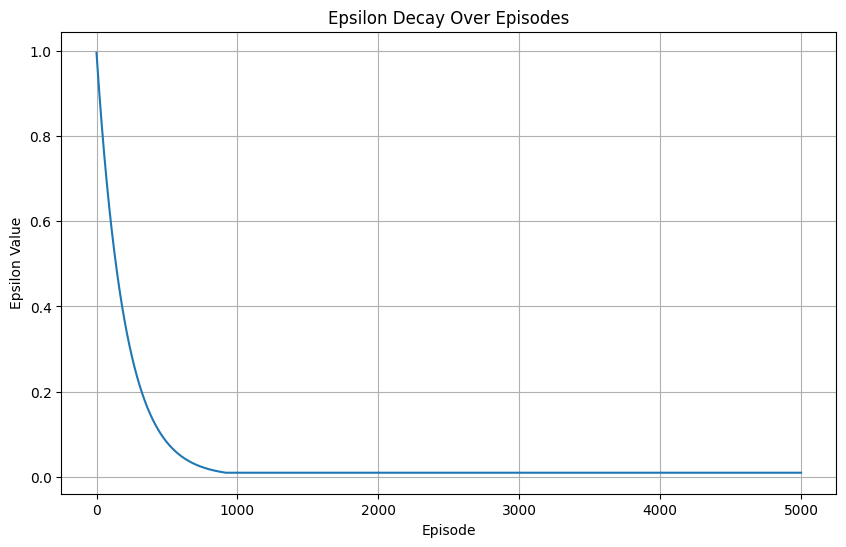

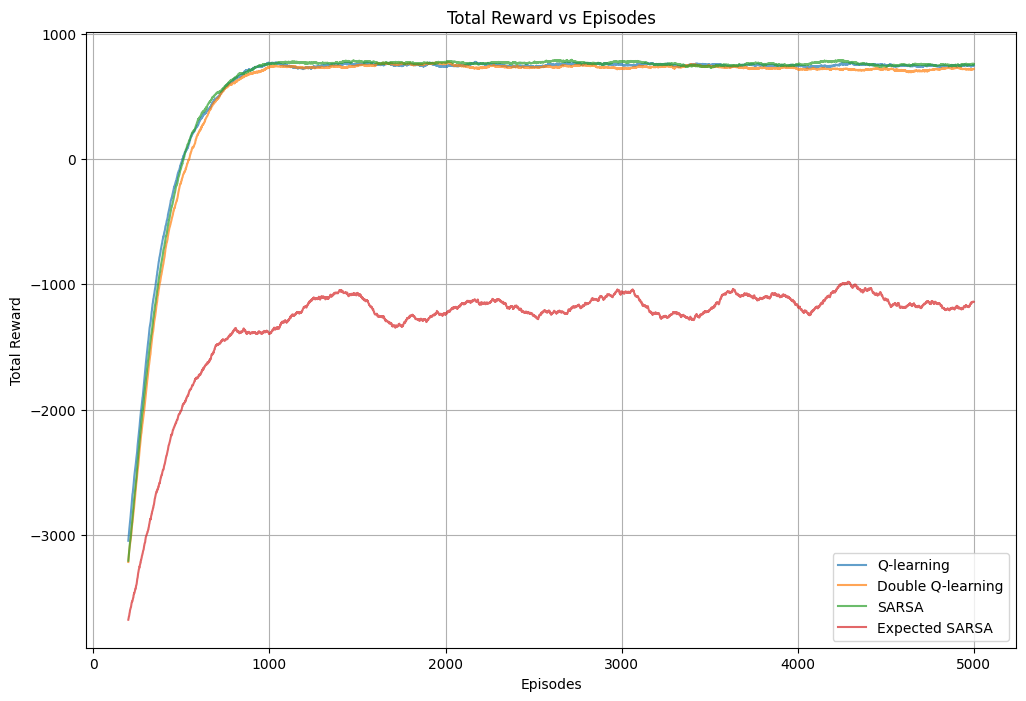

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def rolling_average(data, window_size):
    """Compute the rolling average of a list."""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

# Window size for the rolling average
window_size = 200  # Adjust this based on your preference

# Calculate rolling averages
episode_rewards_smoothed = rolling_average(episode_rewards, window_size)
episode_rewards_double_smoothed = rolling_average(episode_rewards_double, window_size)
episode_rewards_sarsa_smoothed = rolling_average(episode_rewards_sarsa, window_size)
episode_rewards_expected_sarsa_smoothed = rolling_average(episode_rewards_expected_sarsa, window_size)

# Adjust episodes range since the first few values don't have a rolling average
episodes_adjusted = range(window_size - 1, total_episodes)

# Plot epsilon decay vs episodes
plt.figure(figsize=(10, 6))
plt.plot(epsilon_values, label='Epsilon')
plt.xlabel('Episode')
plt.ylabel('Epsilon Value')
plt.title('Epsilon Decay Over Episodes')
#plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12, 8))
plt.plot(episodes_adjusted, episode_rewards_smoothed, label='Q-learning', alpha=0.7)
plt.plot(episodes_adjusted, episode_rewards_double_smoothed, label='Double Q-learning', alpha=0.7)
plt.plot(episodes_adjusted, episode_rewards_sarsa_smoothed, label='SARSA', alpha=0.7)
plt.plot(episodes_adjusted, episode_rewards_expected_sarsa_smoothed, label='Expected SARSA', alpha=0.7)
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Total Reward vs Episodes')
plt.legend()
plt.grid(True)
plt.show()